In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

## Read in netCDF data

In [2]:
from scipy.io import netcdf_file

# https://resources.marine.copernicus.eu/product-download/SEALEVEL_EUR_PHY_L4_MY_008_068
f = netcdf_file("data2.nc")
f.variables

{'ugos': <scipy.io._netcdf.netcdf_variable at 0x7f3752654250>,
 'vgos': <scipy.io._netcdf.netcdf_variable at 0x7f3729f363a0>,
 'vgosa': <scipy.io._netcdf.netcdf_variable at 0x7f3729f363d0>,
 'crs': <scipy.io._netcdf.netcdf_variable at 0x7f3729f36460>,
 'err_vgosa': <scipy.io._netcdf.netcdf_variable at 0x7f3729f364f0>,
 'latitude': <scipy.io._netcdf.netcdf_variable at 0x7f3729f365b0>,
 'nv': <scipy.io._netcdf.netcdf_variable at 0x7f3729f36640>,
 'sla': <scipy.io._netcdf.netcdf_variable at 0x7f3729f366d0>,
 'ugosa': <scipy.io._netcdf.netcdf_variable at 0x7f3729f36820>,
 'lat_bnds': <scipy.io._netcdf.netcdf_variable at 0x7f3729f36880>,
 'flag_ice': <scipy.io._netcdf.netcdf_variable at 0x7f3729f36910>,
 'adt': <scipy.io._netcdf.netcdf_variable at 0x7f3729f369d0>,
 'err_ugosa': <scipy.io._netcdf.netcdf_variable at 0x7f3729f36a30>,
 'tpa_correction': <scipy.io._netcdf.netcdf_variable at 0x7f3729f36ac0>,
 'time': <scipy.io._netcdf.netcdf_variable at 0x7f3729f36b50>,
 'longitude': <scipy.io._n

In [5]:
lat = f.variables['latitude'].data
long = f.variables['longitude'].data
vel_x = f.variables['ugos'].data.squeeze()
print(vel_x.shape[0])
vel_y = f.variables['vgos'].data.squeeze()
print(vel_y.shape)
from common_functions import interpolate_missing_point

imputed_vel_x = interpolate_missing_point(vel_x, np.ma.masked_invalid(vel_x).mask)
imputed_vel_y = interpolate_missing_point(vel_y, np.ma.masked_invalid(vel_y).mask)

321
(321, 81)


In [55]:
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp
from scipy.spatial.distance import euclidean


# first build an interpolator over the x and y velocity
# for now dont use any proper coordinates just [0,m]*[0,n]
m,n = imputed_vel_x.shape
i = np.linspace(0, m, m)
j = np.linspace(0, n, n)
method = "linear"

interp_vel_x = RegularGridInterpolator((i, j), imputed_vel_x, method=method)
interp_vel_y = RegularGridInterpolator((i, j), imputed_vel_y, method=method)

def rhs(t, x):
    return [interp_vel_x(x).squeeze(), interp_vel_y(x).squeeze()]
    
def streamline(i,j, *, steps, step_size, dist_tol, winding_tol):
    #print(i,j, flush=True)
    winding_angle = 0
    theta_prev = 0
    closed = False
    
    start_i = i
    start_j = j
    
    trajectory = [[i,j]]
    
    for k in range(steps):
        try:
            v = rhs(0,[i,j])
        except:
            break
        
        # integrate
        i += step_size*v[1]
        j += step_size*v[0]
        
        theta = np.arctan2(v[1], v[0])
        
        if k > 1:
            winding_angle += theta - theta_prev
           
        if k > 500 and (dist:=euclidean([i,j],[start_i,start_j])) < dist_tol:
            closed = True
            break
            
            
        theta_prev = theta
        trajectory.append([i,j])
    
    if (winding_angle % (2*np.pi) < winding_tol or winding_angle % (-2*np.pi) < winding_tol) and closed:
        print(f"{dist=} {winding_angle=} {closed=}")
        return np.asarray(trajectory).T
    return None
        
        
from multiprocessing import Pool
from functools import partial
from itertools import product

step = 5

i_points = range(0, imputed_vel_x.shape[0], step)
j_points = range(0, imputed_vel_x.shape[1], step)

with Pool() as p:
    func = partial(streamline, steps=5000, step_size=0.1, dist_tol=0.5, winding_tol=0.3)
    
    res = p.starmap(func, product(i_points,j_points))

eddies = []

for result in res:
    if result is not None:
        eddies.append(np.mean(result, axis=-1))

eddies = np.asarray(eddies)


dist=0.49994462168715514 winding_angle=-5.443270310026148 closed=True
dist=0.49448070308007175 winding_angle=-0.21927741007316665 closed=True
dist=0.4956824968758039 winding_angle=-0.17242334630620215 closed=True
dist=0.4610284005908231 winding_angle=4.801267466225753 closed=True
dist=0.3848661394125824 winding_angle=-1.9451160519425819 closed=True
dist=0.48005260362775515 winding_angle=-0.03829619605683576 closed=True
dist=0.499215218398859 winding_angle=-0.12781409515158038 closed=True
dist=0.4959574837821207 winding_angle=-0.20483987818161142 closed=True
dist=0.49485102044710205 winding_angle=-0.04552212765698993 closed=True
dist=0.49447215615831575 winding_angle=-0.1551312584613549 closed=True
dist=0.4968903145222767 winding_angle=0.1951040600506042 closed=True
dist=0.06380940315336034 winding_angle=0.6027008492569585 closed=True
dist=0.4996598628735376 winding_angle=0.33671790071602525 closed=True
dist=0.49814214970361836 winding_angle=-0.27222074839757493 closed=True
dist=0.28874

dist=0.4989115205565881 winding_angle=-0.2199740584186487 closed=True
dist=0.4951668125920836 winding_angle=-0.21111508124971268 closed=True
dist=0.49881612404245607 winding_angle=0.4748753218834101 closed=True
dist=0.4969779576919433 winding_angle=0.06638485994167431 closed=True
dist=0.49899528876874966 winding_angle=0.7842530477237439 closed=True
dist=0.49400620649599897 winding_angle=0.21776425948224748 closed=True
dist=0.49839713390580886 winding_angle=-0.005957213051596577 closed=True
dist=0.4922536152952052 winding_angle=0.0666481728028735 closed=True
dist=0.48135762805514914 winding_angle=0.0654022872158248 closed=True
dist=0.497945487889785 winding_angle=1.0041576564557726 closed=True
dist=0.49950252997193645 winding_angle=1.0225142243014096 closed=True
dist=0.49773868659419995 winding_angle=0.14112647757580454 closed=True
dist=0.49996801709315675 winding_angle=-0.3506728733067106 closed=True
dist=0.3506417196235426 winding_angle=-3.957194753785944 closed=True
dist=0.4928170783

<IPython.core.display.Javascript object>


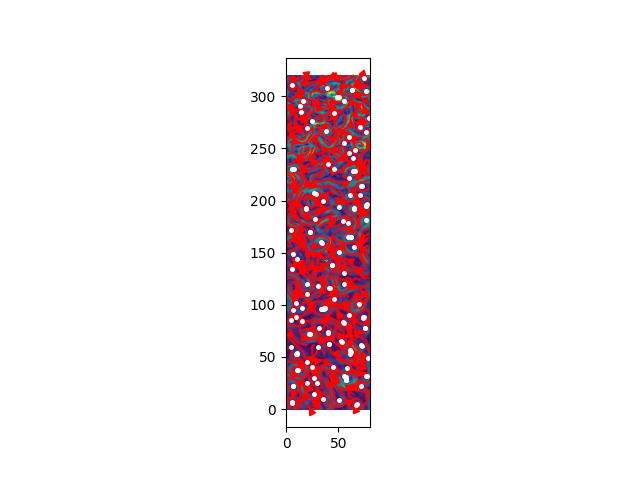

In [56]:
plt.figure()
plt.imshow(np.hypot(imputed_vel_x, imputed_vel_y), origin='lower',)
y = np.arange(0, imputed_vel_x.shape[0])
x = np.arange(0, imputed_vel_x.shape[1])
X, Y = np.meshgrid(x, y)
plt.streamplot(X,Y,imputed_vel_x, imputed_vel_y, density=2, maxlength=20,color='r')
plt.plot(eddies[:,1], eddies[:,0], 'w.', markersize=5, label="Eddy Centre")


NameError: name 'i' is not defined